In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('train.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
data.shape

(404290, 6)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Distribution of the output column

In [5]:
data["is_duplicate"].value_counts()

,count
is_duplicate,
0,255027
1,149263


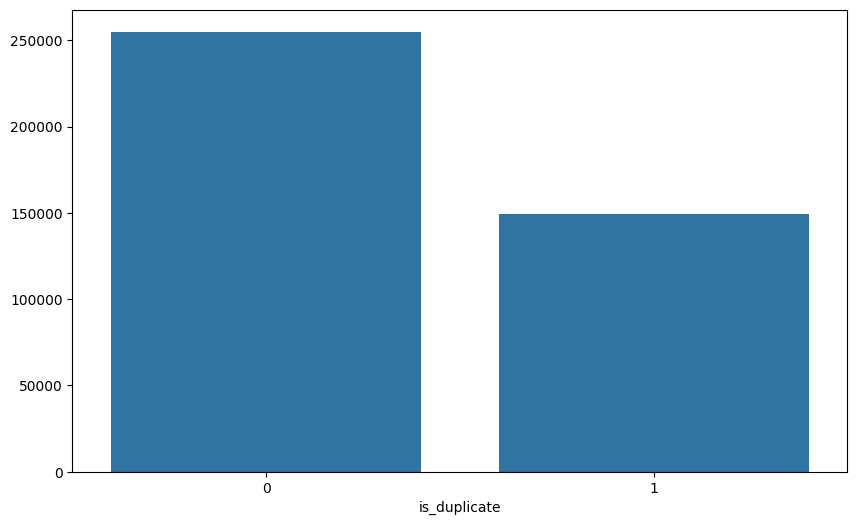

In [6]:
output_count_df = data["is_duplicate"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=output_count_df.index, y=output_count_df.values)
plt.show()

In [7]:
print(f"Total number of question pairs available for training: {data.shape[0]}")

Total number of question pairs available for training: 404290


In [8]:
print(f"Total number of question pairs that are NOT SIMILAR: {round((output_count_df[0] / data.shape[0]) * 100, 2)}%")
print(f"Total number of question pairs that are SIMILAR: {round((output_count_df[1] / data.shape[0]) * 100, 2)}%")

Total number of question pairs that are NOT SIMILAR: 63.08%
Total number of question pairs that are SIMILAR: 36.92%


## Number of unique questions in the train data

Total number of unique questions: 537933
Total number of questions that appear more than one time: 111780 (20.78%)
The maximun number of times a single question repeated: 157


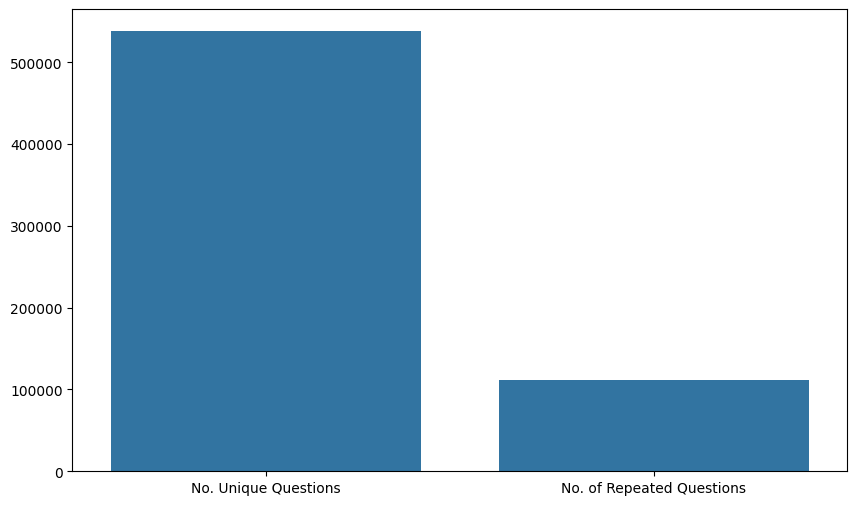

In [9]:
question_ids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
no_of_uniue_questions_ids = question_ids.nunique()

temp_df = question_ids.value_counts()
questions_more_than_one_time = np.sum(temp_df > 1)

temp = (questions_more_than_one_time / no_of_uniue_questions_ids) * 100

print(f"Total number of unique questions: {no_of_uniue_questions_ids}")
print(f"Total number of questions that appear more than one time: {questions_more_than_one_time} ({round(temp, 2)}%)")
print(f"The maximun number of times a single question repeated: {temp_df.values.max()}")

x = ["No. Unique Questions", "No. of Repeated Questions"]
y = [no_of_uniue_questions_ids, questions_more_than_one_time]

plt.figure(figsize=(10, 6))
sns.barplot(x=x, y=y)
plt.show()


## Checking for the presence of duplicate pairs

In [10]:
duplicate_pairs = data[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()
print(f"Total number of duplicate pairs: {duplicate_pairs.shape[0] - data.shape[0]}")

Total number of duplicate pairs: 0


In [11]:
duplicate_pairs

,qid1,qid2,is_duplicate
0,1,2,1
1,3,4,1
2,3,282170,1
3,3,380197,1
4,3,488853,1
...,...,...,...
404285,537924,537925,1
404286,537926,537927,1
404287,537928,537929,1
404288,537930,537931,1


## Visualizing the no. of occurences of each question

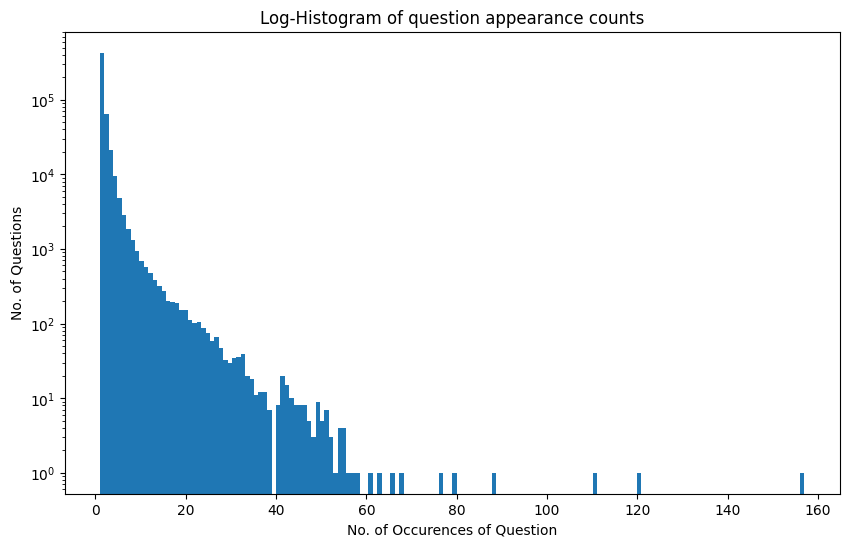

Maximum number of times a single question is repeated: 157


In [12]:
plt.figure(figsize=(10, 6))
plt.hist(question_ids.value_counts(), bins=160)
plt.title("Log-Histogram of question appearance counts")
plt.xlabel("No. of Occurences of Question")
plt.ylabel("No. of Questions")
plt.yscale('log')
plt.show()

print(f"Maximum number of times a single question is repeated: {max(question_ids.value_counts())}")

## Missing Data

In [13]:
missing_data_rows = data[data.isnull().any(axis=1)]
missing_data_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


# Basic Feature Extraction

In [14]:
data = data.fillna('')
nan_rows = data[data.isnull().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [15]:
def create_features(df):
  df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
  df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
  df['q1len'] = df['question1'].str.len()
  df['q2len'] = df['question2'].str.len()
  df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
  df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

  def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)

  def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))

  def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2) / (len(w1) + len(w2))

  df['word_Common'] = df.apply(normalized_word_Common, axis=1)
  df['word_Total'] = df.apply(normalized_word_Total, axis=1)
  df['word_share'] = df.apply(normalized_word_share, axis=1)

  df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
  df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

  return df

In [16]:
%%time
data = create_features(data.copy())

CPU times: user 22.5 s, sys: 577 ms, total: 23.1 s
Wall time: 23.3 s


In [17]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


## Analysing the Extracted features

##### Questions that have only single word

In [18]:
print("Minimun lenght of the questions in question1: ", min(data['q1_n_words']))
print("Minimun lenght of the questions in question2: ", min(data['q2_n_words']))
print("Number of Questions with minimum length [question1]: ", data[data['q1_n_words'] == 1].shape[0])
print("Number of Questions with minimum length [question2]: ", data[data['q2_n_words'] == 1].shape[0])


Minimun lenght of the questions in question1:  1
Minimun lenght of the questions in question2:  1
Number of Questions with minimum length [question1]:  67
Number of Questions with minimum length [question2]:  24


##### Analysing word_share feature

<ipython-input-19-05dd9b49adc0>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'][0:], label="1", color='red')
<ipython-input-19-05dd9b49adc0>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'][0:], labe

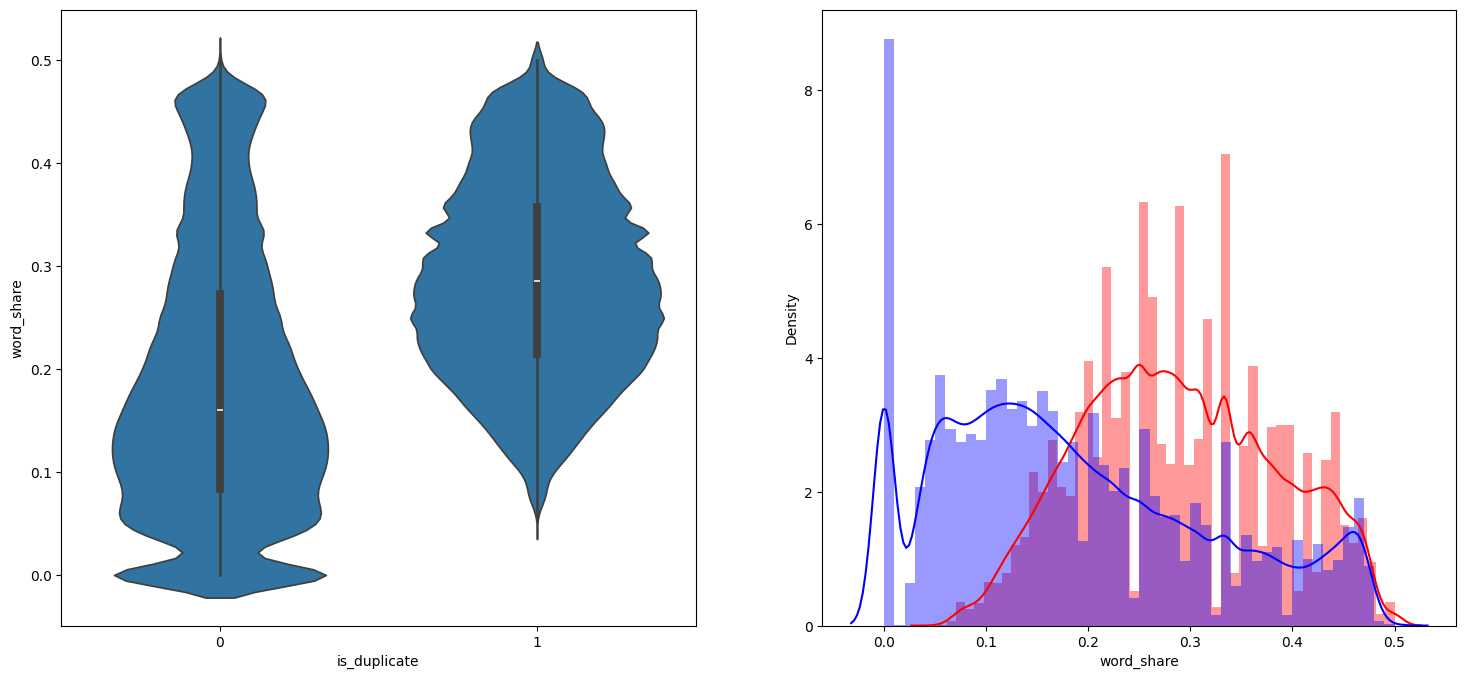

In [19]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_share', data=data)

plt.subplot(1, 2, 2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'][0:], label="1", color='red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'][0:], label="0", color='blue')
plt.show()

##### Analysing word_common feature

<ipython-input-20-4932b5d4bec2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['is_duplicate'] == 1.0]['word_Common'][0:], label="1", color='red')
<ipython-input-20-4932b5d4bec2>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['is_duplicate'] == 0.0]['word_Common'][0:], la

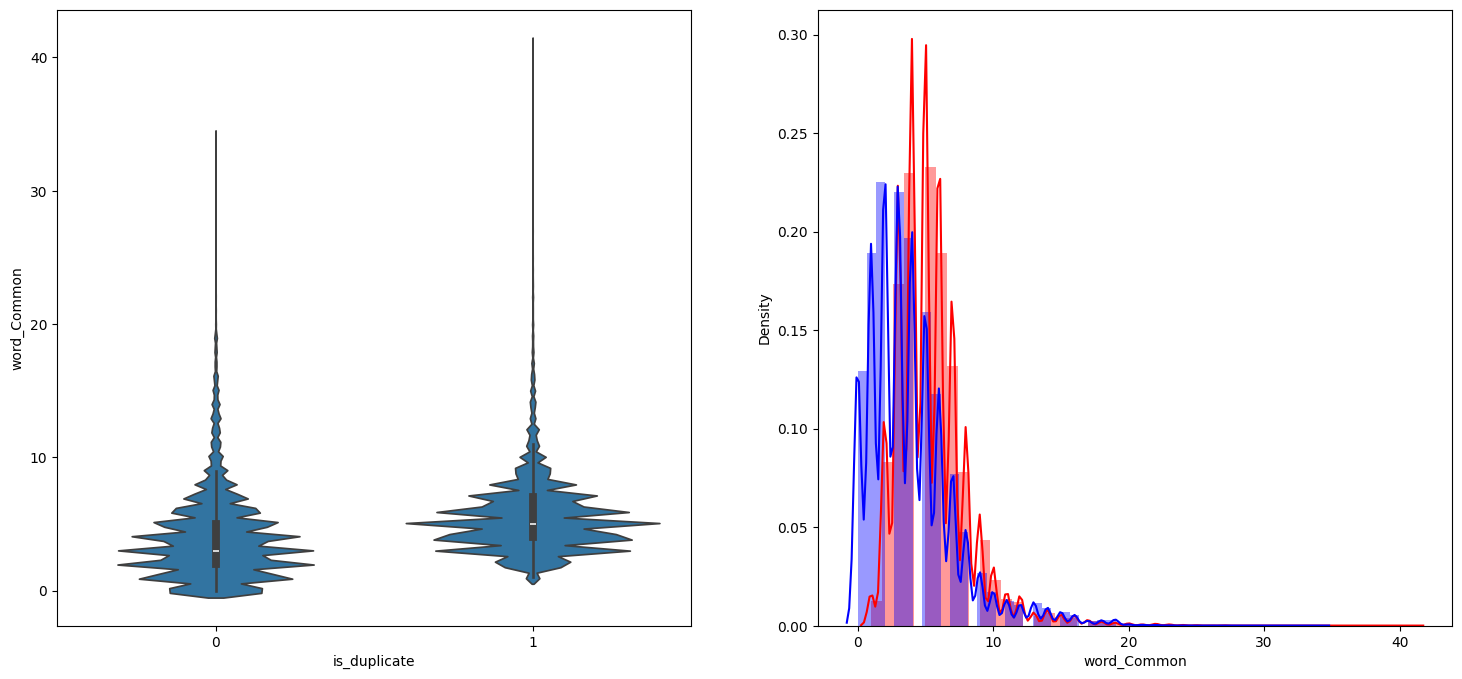

In [20]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_Common', data=data)

plt.subplot(1, 2, 2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_Common'][0:], label="1", color='red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_Common'][0:], label="0", color='blue')
plt.show()

In [21]:
data.to_csv("train_with_simple_features.csv", index=False)

In [22]:
!pip install distance fuzzywuzzy python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.1 MB/s eta 0:00:00
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16256 sha256=b795d3329518de02bafe6c9a4056f5de29a07753db328f5564636ebbc2fc768e
  Stored in directory: /root/.cache/pip/wheels/fb/cd/9c/3ab5d666e3bcacc58900b10959edd3816cc9557c7337986322
Successfully built distance


In [23]:
import nltk
nltk.download('stopwords')

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import distance
from fuzzywuzzy import fuzz

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
data = pd.read_csv('train_with_simple_features.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


# Preprocessing the text

In [25]:
STOP_WORDS = stopwords.words('english')

def preprocess(x):
  x = str(x).lower()
  x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")

  x = re.sub(r"([0-9]+)000000", r"\1m", x)
  x = re.sub(r"([0-9]+)000", r"\1k", x)

  porter = PorterStemmer()
  pattern = re.compile('\W')

  if type(x) == type(''):
    x = re.sub(pattern, ' ', x)

  if type(x) == type(''):
    x = porter.stem(x)
    example1 = BeautifulSoup(x)
    x = example1.get_text()

  return x

# Advance Feature Engineering

In [26]:
SAFE_DIV = 0.0001

def get_token_features(q1, q2):
  token_features = [0.0] * 10

  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
    return token_features

  q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

  common_word_count = len(q1_words.intersection(q2_words))
  common_stop_count = len(q1_stops.intersection(q2_stops))
  common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
  token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
  token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
  token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])
  token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
  token_features[9] = (len(q1_tokens) + len(q2_tokens)) / 2

  return token_features

In [27]:
def get_longest_substr_ratio(a, b):
  strs = list(distance.lcsubstrings(a, b))
  if len(strs) == 0:
    return 0
  else:
    return len(strs[0]) / (min(len(a), len(b)) + 1)

In [28]:
def extract_features(df):
  print("Preprocessing the Questions...")
  df['question1'] = df['question1'].fillna('').apply(preprocess)
  df['question2'] = df['question2'].fillna('').apply(preprocess)

  print("Extracting Token Features...")

  token_features = df.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)

  df["cwc_min"] = list(map(lambda x: x[0], token_features))
  df["cwc_max"] = list(map(lambda x: x[1], token_features))
  df["csc_min"] = list(map(lambda x: x[2], token_features))
  df["csc_max"] = list(map(lambda x: x[3], token_features))
  df["ctc_min"] = list(map(lambda x: x[4], token_features))
  df["ctc_max"] = list(map(lambda x: x[5], token_features))
  df["last_word_eq"] = list(map(lambda x: x[6], token_features))
  df["first_word_eq"] = list(map(lambda x: x[7], token_features))
  df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
  df["mean_len"] = list(map(lambda x: x[9], token_features))

  print("Extracting Fuzzy Features...")

  df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)

  df["token_sort_ratio"] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
  df["fuzz_ratio"] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
  df["fuzz_partial_ratio"] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
  df["longest_substr_ratio"] = df.apply(lambda x: get_longest_substr_ratio(x['question1'], x['question2']), axis=1)

  return df

In [29]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [30]:
data.shape

(404290, 17)

In [31]:
%%time
data = extract_features(data.copy())

Preprocessing the Questions...
Extracting Token Features...
Extracting Fuzzy Features...
CPU times: user 10min 23s, sys: 9.37 s, total: 10min 32s
Wall time: 10min 56s


In [32]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [33]:
data.shape

(404290, 32)

In [34]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [35]:
!pip install chart_studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.0 MB/s eta 0:00:00


In [36]:
from wordcloud import WordCloud, STOPWORDS

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

np.random.seed(24)

import chart_studio.plotly as py
import plotly.offline as pyo

pyo.init_notebook_mode(connected=True)
import plotly.graph_objs as go


# Analysis of Extracted Feature

### Plotting Word Clouds

In [37]:
df_duplicate = data[data['is_duplicate'] == 1]
df_not_duplicate = data[data['is_duplicate'] == 0]

p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_not_duplicate['question1'], df_not_duplicate['question2']]).flatten()

print("Number of data points in class 1 (duplicate pairs): ", len(p))
print("Number of data points in class 0 (non-duplicate pairs): ", len(n))

np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding='utf-8')

Number of data points in class 1 (duplicate pairs):  298526
Number of data points in class 0 (non-duplicate pairs):  510054


In [38]:

textp_w = open('train_p.txt', encoding='utf-8').read()
textn_w = open('train_n.txt', encoding='utf-8').read()

stopwords = set(STOP_WORDS)

stopwords.add('said')
stopwords.add('br')
stopwords.add(' ')

if 'like' in stopwords:
    stopwords.remove('like')

stopwords.remove('not')
stopwords.remove('no')
#stopwords.remove('like')

print("Total number of words in duplicate pair questions: ", len(textp_w))
print("Total number of words in non-duplicate pair questions: ", len(textn_w))

Total number of words in duplicate pair questions:  16109886
Total number of words in non-duplicate pair questions:  33193067


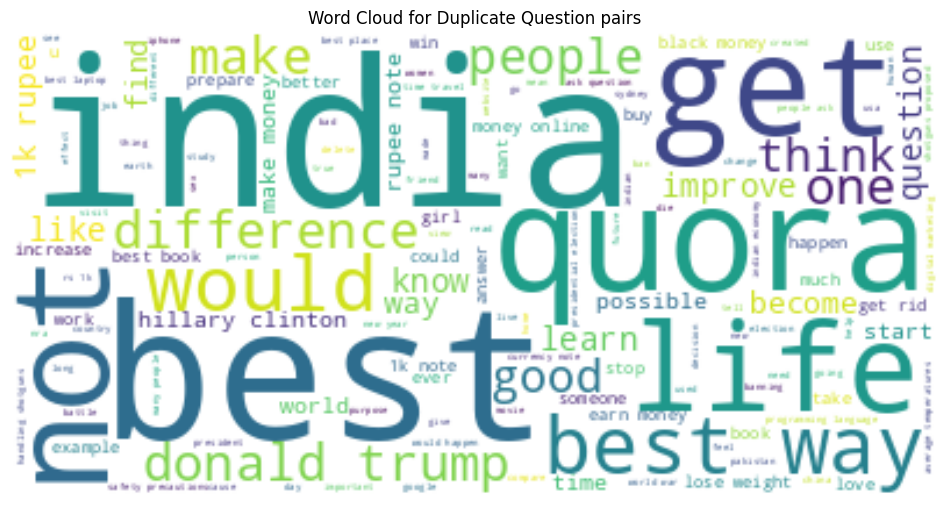

In [39]:
wc = WordCloud(background_color='white', max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud for Duplicate Question pairs")
plt.axis('off')
plt.show()

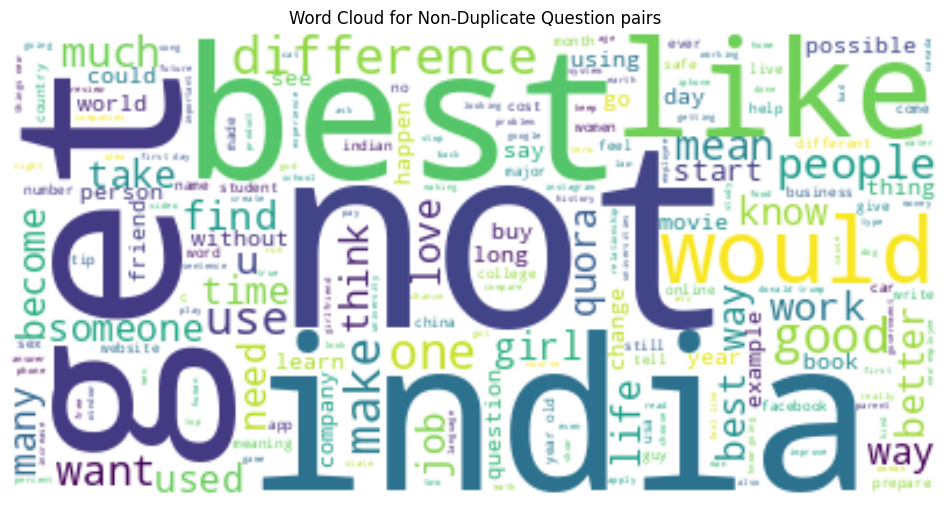

In [40]:
wc = WordCloud(background_color='white', max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.title("Word Cloud for Non-Duplicate Question pairs")
plt.axis('off')
plt.show()

### Pair Plots of Advance Features

<Figure size 1800x1600 with 0 Axes>

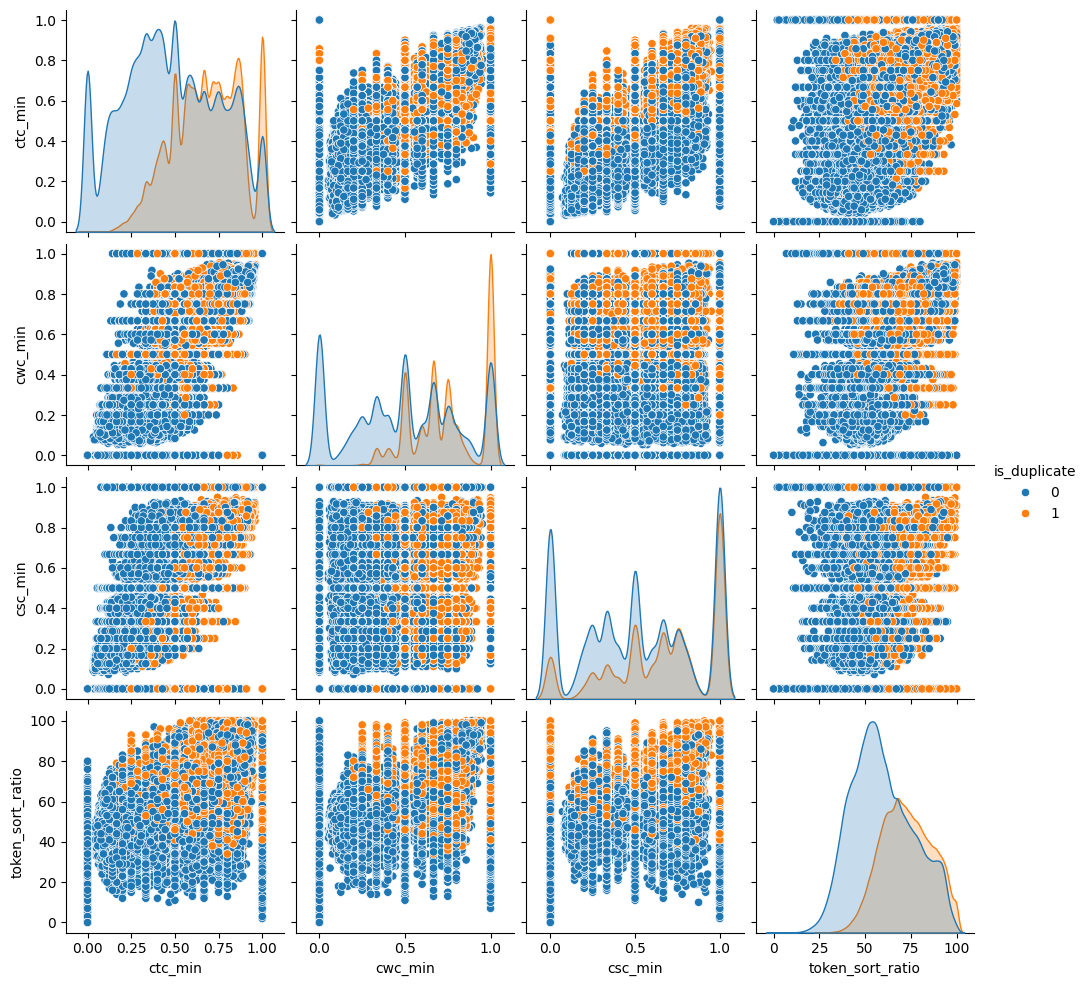

In [41]:
feature_columns = ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']

plt.figure(figsize=(18, 16))
sns.pairplot(data[feature_columns], hue='is_duplicate', vars=feature_columns[:-1])
plt.show()

<ipython-input-42-b6e1cd775534>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-42-b6e1cd775534>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




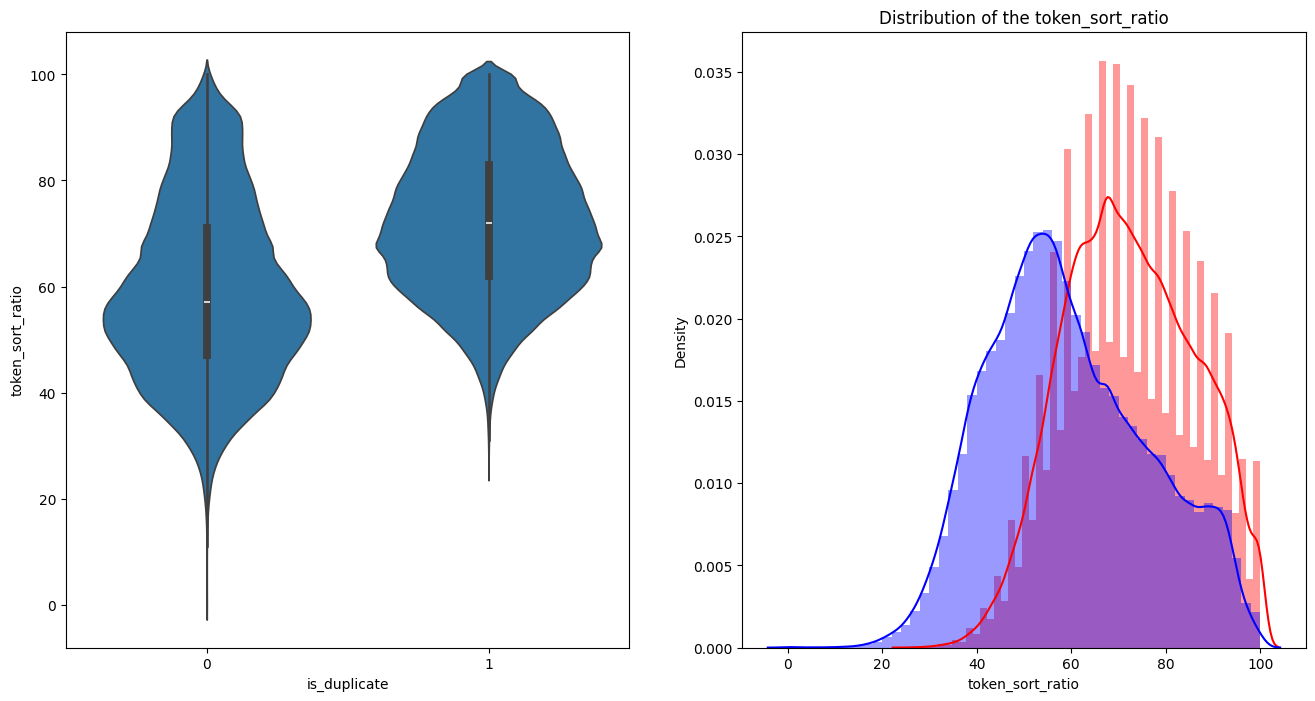

In [42]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=data)

plt.subplot(1, 2, 2)
sns.distplot(data[data['is_duplicate'] == 1.0]['token_sort_ratio'], label="1", color='red')
sns.distplot(data[data['is_duplicate'] == 0.0]['token_sort_ratio'], label="0", color='blue')
plt.title("Distribution of the token_sort_ratio")
plt.show()

<ipython-input-43-d7c7d651cc67>:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-43-d7c7d651cc67>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




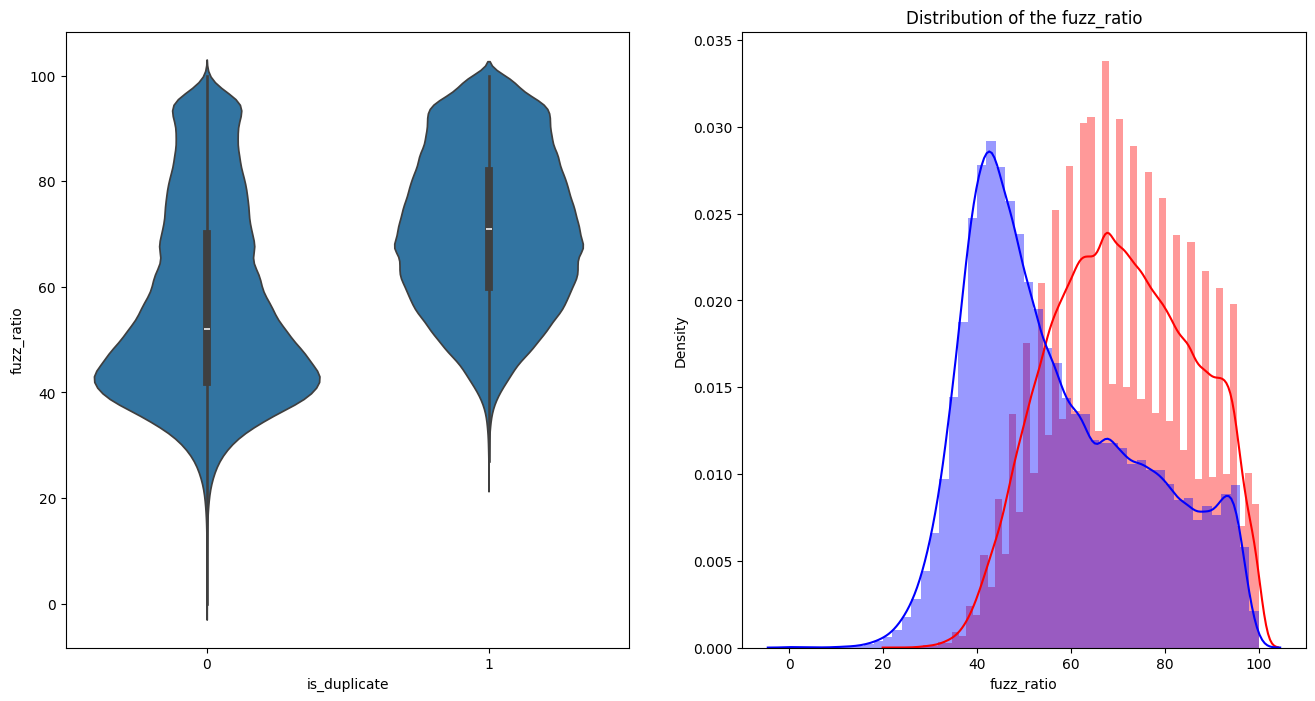

In [43]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio', data=data)

plt.subplot(1, 2, 2)
sns.distplot(data[data['is_duplicate'] == 1.0]['fuzz_ratio'], label="1", color='red')
sns.distplot(data[data['is_duplicate'] == 0.0]['fuzz_ratio'], label="0", color='blue')
plt.title("Distribution of the fuzz_ratio")
plt.show()

In [44]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

#### Visualization

In [45]:
dfp_subsampled = data[0:5000]
columns = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']

X = MinMaxScaler().fit_transform(dfp_subsampled[columns])
y = dfp_subsampled['is_duplicate'].values

In [46]:
tsne2d = TSNE(n_components=2, init='random', random_state=101, method='barnes_hut', n_iter=1000, verbose=2,angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.023s...
[t-SNE] Computed neighbors for 5000 samples in 0.637s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116488
[t-SNE] Computed conditional probabilities in 0.254s
[t-SNE] Iteration 50: error = 85.3321228, gradient norm = 0.0972664 (50 iterations in 2.623s)
[t-SNE] Iteration 100: error = 70.6867752, gradient norm = 0.0129675 (50 iterations in 1.938s)
[t-SNE] Iteration 150: error = 68.6587219, gradient norm = 0.0080887 (50 iterations in 1.922s)
[t-SNE] Iteration 200: error = 67.7094879, gradient norm = 0.0055748 (50 iterations in 2.020s)
[t-SNE] Iteration 250: error = 67.1832352, gradient norm = 0.0042725

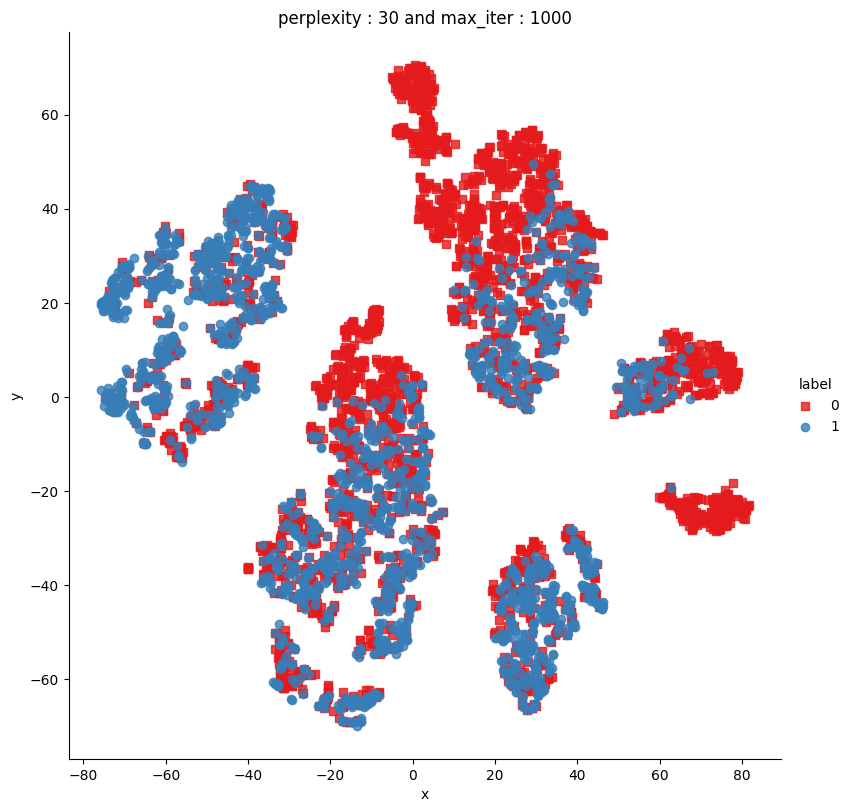

In [47]:
df = pd.DataFrame({'x': tsne2d[:, 0], 'y': tsne2d[:, 1], 'label': y})

sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=8, palette='Set1', markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [48]:
tsne3d = TSNE(n_components=3, init='random', random_state=101, method='barnes_hut', n_iter=1000, verbose=2,angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.409s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116488
[t-SNE] Computed conditional probabilities in 0.150s
[t-SNE] Iteration 50: error = 86.2642593, gradient norm = 0.0803451 (50 iterations in 9.007s)
[t-SNE] Iteration 100: error = 69.4343033, gradient norm = 0.0073584 (50 iterations in 5.550s)
[t-SNE] Iteration 150: error = 67.7207642, gradient norm = 0.0037860 (50 iterations in 4.262s)
[t-SNE] Iteration 200: error = 67.1080704, gradient norm = 0.0025442 (50 iterations in 5.379s)
[t-SNE] Iteration 250: error = 66.7634048, gradient norm = 0.0019961

In [49]:
trace1 = go.Scatter3d(
    x=tsne3d[:, 0],
    y=tsne3d[:, 1],
    z=tsne3d[:, 2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale='Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

df=[trace1]
layout = dict(height=800, width=800, title='3d embedding with engineered features')

fig = dict(data=df, layout=layout)
pyo.iplot(fig, filename='3DBubble')

#### Generating features from the text data using Weghted Word Vectors

In [50]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm

In [51]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [52]:
data.shape

(404290, 32)

In [53]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    404290 non-null  int64  
 1   qid1                  404290 non-null  int64  
 2   qid2                  404290 non-null  int64  
 3   question1             404290 non-null  object 
 4   question2             404290 non-null  object 
 5   is_duplicate          404290 non-null  int64  
 6   freq_qid1             404290 non-null  int64  
 7   freq_qid2             404290 non-null  int64  
 8   q1len                 404290 non-null  int64  
 9   q2len                 404290 non-null  int64  
 10  q1_n_words            404290 non-null  int64  
 11  q2_n_words            404290 non-null  int64  
 12  word_Common           404290 non-null  float64
 13  word_Total            404290 non-null  float64
 14  word_share            404290 non-null  float64
 15  

In [55]:
%%time
questions = list(data['question1']) + list(data['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

CPU times: user 10.5 s, sys: 98.4 ms, total: 10.6 s
Wall time: 10.8 s


In [56]:
nlp = spacy.load('en_core_web_sm')
vecs1 = []
for qu1 in list(data['question1']):
    doc1 = nlp(qu1)

    if len(doc1) > 0:
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            vec1 = word1.vector
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
        vecs1.append(mean_vec1)

    else:
        vecs1.append(np.zeros(300))
data['q1_feats_m'] = list(vecs1)

In [57]:
vecs2 = []
for qu2 in list(data['question2']):
    doc2 = nlp(qu2)

    if len(doc2) > 0:
        mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
        for word2 in doc2:
            vec2 = word2.vector
            try:
                idf = word2tfidf[str(word2)]
            except:
                idf = 0
            mean_vec2 += vec2 * idf
        mean_vec2 = mean_vec2.mean(axis=0)
        vecs2.append(mean_vec2)
    else:
        vecs2.append(np.zeros(300))

data['q2_feats_m'] = list(vecs2)

In [58]:
'''glove_nlp = spacy.load('en_core_web_sm')

len(glove_nlp("man").vector), len(glove_nlp("boy").vector), len(glove_nlp("cloudy").vector)'''

'glove_nlp = spacy.load(\'en_core_web_sm\')\n\nlen(glove_nlp("man").vector), len(glove_nlp("boy").vector), len(glove_nlp("cloudy").vector)'

In [59]:
'''def get_weighted_vectors(data, column):
  vectors = []
  for sentence in tqdm(list(data[column])):
    doc = glove_nlp(sentence)
    mean_vector = np.zeros([len(doc), 300])
    for word in doc:
      vector = word.vector
      try:
        idf = word2tfidf[str(word)]
      except:
        idf = 0
      mean_vector += vector * idf
    mean_vector = mean_vector.mean(axis=0)
    vectors.append(mean_vector)
  return list(vectors)'''


'def get_weighted_vectors(data, column):\n  vectors = []\n  for sentence in tqdm(list(data[column])):\n    doc = glove_nlp(sentence)\n    mean_vector = np.zeros([len(doc), 300])\n    for word in doc:\n      vector = word.vector\n      try:\n        idf = word2tfidf[str(word)]\n      except:\n        idf = 0\n      mean_vector += vector * idf\n    mean_vector = mean_vector.mean(axis=0)\n    vectors.append(mean_vector)\n  return list(vectors)'

In [60]:
'''%%time
data['q1_feats_m'] = get_weighted_vectors(data, 'question1')'''

"%%time\ndata['q1_feats_m'] = get_weighted_vectors(data, 'question1')"

In [61]:
'''%%time
data['q2_feats_m'] = get_weighted_vectors(data, 'question2')'''

"%%time\ndata['q2_feats_m'] = get_weighted_vectors(data, 'question2')"

In [62]:
#glove_nlp(data['question1'][0])[0].vector.shape

In [63]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,1.0,2.0,13.0,100,93,93,100,0.982759,"[19.92786756157875, -51.57482733204961, 5.7796...","[17.889530688524246, -51.60567643120885, 8.359..."
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,1.0,5.0,12.5,86,63,66,75,0.596154,"[-13.423733472824097, -39.707716055214405, -9....","[-26.588983178138733, -67.74723961949348, -19...."
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,1.0,4.0,12.0,66,66,54,54,0.166667,"[-11.740975975990295, -15.828198321163654, 0.7...","[12.049167722463608, -16.86530427634716, -3.79..."
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.0,2.0,12.0,36,36,35,40,0.039216,"[49.61429822444916, -30.53542149066925, -3.060...","[-19.06930547952652, -28.752208799123764, -16...."
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,1.0,6.0,10.0,67,47,46,56,0.175000,"[-25.566662073135376, -62.1172838807106, -1.01...","[-10.463158965110779, -38.28575265407562, 10.6..."


In [64]:
data.shape

(404290, 34)

In [65]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'q1_feats_m',
       'q2_feats_m'],
      dtype='object')

In [66]:
%%time
df_q1 = pd.DataFrame(data.q1_feats_m.values.tolist(), index=data.index)
df_q2 = pd.DataFrame(data.q2_feats_m.values.tolist(), index=data.index)

CPU times: user 1min 3s, sys: 13.4 s, total: 1min 16s
Wall time: 1min 19s


In [67]:
df_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,19.927868,-51.574827,5.779697,-19.920604,13.799583,-5.782905,45.833250,35.156459,-14.497306,18.881228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-13.423733,-39.707716,-9.102371,10.171264,-19.193224,11.439351,33.165455,30.458034,23.678053,-7.580904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-11.740976,-15.828198,0.753064,-7.361027,5.767634,-10.530237,29.009842,9.938486,-18.906985,6.115969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,49.614298,-30.535421,-3.060925,-1.383086,-25.559696,-13.107953,19.394564,6.736492,2.029878,-6.707574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-25.566662,-62.117284,-1.016737,-46.420997,-31.194780,13.656077,43.363074,67.188430,11.427759,13.504630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
df_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,17.889531,-51.605676,8.359492,-17.849997,8.038130,-6.574708,39.960908,38.540004,-13.708079,19.283525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-26.588983,-67.747240,-19.854884,10.658309,-28.688355,-7.984219,24.801514,9.739724,15.921516,-3.617469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12.049168,-16.865304,-3.791068,3.766215,-25.433276,-8.114878,23.853137,27.374261,-5.084556,9.314438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-19.069305,-28.752209,-16.922552,49.536523,9.353281,-15.826421,-24.005498,29.157002,-10.344089,-37.030846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-10.463159,-38.285753,10.671579,-6.837499,-25.958391,-4.806808,30.847631,13.368681,-3.818866,3.499553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df_q1.shape, df_q2.shape

((404290, 300), (404290, 300))

In [70]:
df_q1["id"] = data["id"]
df_q2["id"] = data["id"]

In [71]:
%%time
final_df = data.merge(df_q1, on='id', how='left').merge(df_q2, on='id', how='left').drop(columns=["q1_feats_m", "q2_feats_m"])

CPU times: user 2.31 s, sys: 6.67 s, total: 8.98 s
Wall time: 9.51 s


In [72]:
final_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
final_df.shape

(404290, 632)

In [74]:
final_df.to_csv("final_train_data.csv", index=False)